In [1]:
import torch, os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
import warnings
import os

# 過濾警告
warnings.filterwarnings("ignore")

# 設定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# 1. 資料處理與 Dataset 定義
# ==========================================

def load_data(file_path='full_dataset.csv'):
    """
    載入並整理資料
    """
    if not os.path.exists(file_path):
        # 建立假資料供測試用 (若您沒有檔案時可避免報錯，實際使用會讀取您的 csv)
        print(f"Warning: {file_path} not found. Creating dummy data for demonstration.")
        df = pd.DataFrame({
            'text': ['Patient has severe fever.', 'Routine checkup, normal.', 'High blood pressure observed.', 'Discharged with medication.'] * 25,
            'los_category': [1, 0, 1, 0] * 25
        })
    else:
        df = pd.read_csv(file_path)
    
    # 確保沒有缺失值
    df = df.dropna(subset=['text', 'los_category'])
    
    texts = df['text'].tolist()
    labels = df['los_category'].astype(int).tolist()
    
    return np.array(texts), np.array(labels)

class MedicalReportDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



Using device: cuda


In [3]:
# ==========================================
# 2. 訓練與評估函式 (包含 Classification Report)
# ==========================================

def train_and_evaluate(model_name, texts, labels, n_splits=10):
    print(f"\n{'='*30}")
    print(f"Processing Model: {model_name}")
    print(f"{'='*30}")
    
    # 初始化 Tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return None, None

    # 設定 Cross-Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # 儲存每一 fold 的指標
    fold_metrics = {
        'accuracy': [],
        'precision_micro': [], 'recall_micro': [], 'f1_micro': [],
        'precision_macro': [], 'recall_macro': [], 'f1_macro': []
    }
    
    # **關鍵修改**: 收集所有 Fold 的真實標籤與預測結果，用於生成最終 Report
    all_true_labels = []
    all_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        train_texts, val_texts = texts[train_idx], texts[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]
        
        train_ds = MedicalReportDataset(train_texts, train_labels, tokenizer)
        val_ds = MedicalReportDataset(val_texts, val_labels, tokenizer)
        
        train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=8)
        
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model = model.to(device)
        
        optimizer = AdamW(model.parameters(), lr=2e-5)
        
        # 簡單設定 epochs (可自行調整)
        epochs = 3
        for epoch in range(epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['labels'].to(device)
                
                optimizer.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
        
        # 驗證
        model.eval()
        fold_preds = []
        fold_true = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                
                fold_preds.extend(preds.cpu().tolist())
                fold_true.extend(targets.cpu().tolist())
        
        # 計算 Fold 指標
        acc = accuracy_score(fold_true, fold_preds)
        p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(fold_true, fold_preds, average='macro')
        
        fold_metrics['accuracy'].append(acc)
        fold_metrics['f1_macro'].append(f1_macro)
        
        # 收集全域結果
        all_true_labels.extend(fold_true)
        all_predictions.extend(fold_preds)
        
        del model
        torch.cuda.empty_cache()

    # 輸出平均指標
    results_df = pd.DataFrame(fold_metrics)
    print(f"\nAverage Accuracy: {results_df['accuracy'].mean():.4f}")
    print(f"Average F1 Macro: {results_df['f1_macro'].mean():.4f}")
    
    # ==========================================
    # **這裡就是您要的 Classification Report**
    # ==========================================
    print(f"\n{'#'*20} Classification Report: {model_name} {'#'*20}")
    # target_names 可根據您的 0 和 1 代表的意義修改
    report = classification_report(all_true_labels, all_predictions, target_names=['Class 0', 'Class 1'], digits=4)
    print(report)
    print(f"{'#'*60}\n")
    
    return results_df, tokenizer


In [4]:
if __name__ == "__main__":
    # 1. 準備資料
    print("Loading data...")
    # 假設 csv 檔名為 full_dataset.csv
    texts, labels = load_data('full_dataset.csv')
    print(f"Data loaded. Total samples: {len(texts)}")

    # 2. 定義模型名稱
    biobert_name = "dmis-lab/biobert-v1.1"
    clinicalbert_name = "emilyalsentzer/Bio_ClinicalBERT"

    # 3. 訓練 BioBERT 並輸出 Report
    # 注意：n_splits=10 會跑比較久，測試時可以先改為 n_splits=2 或 5
    biobert_results, biobert_tokenizer = train_and_evaluate(biobert_name, texts, labels, n_splits=10)

    # 4. 訓練 BioClinicalBERT 並輸出 Report
    clinicalbert_results, clinicalbert_tokenizer = train_and_evaluate(clinicalbert_name, texts, labels, n_splits=10)

    print("\nAll training finished.")

Loading data...
Data loaded. Total samples: 6606

Processing Model: dmis-lab/biobert-v1.1

--- Fold 1/10 ---


2025-11-21 15:26:39.961099: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 15:26:40.034613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 15:26:41.508401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Some weights of BertForSequenceClassification were not initialized from the mode

OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 23.56 GiB of which 37.38 MiB is free. Process 85040 has 872.00 MiB memory in use. Process 673814 has 6.72 GiB memory in use. Process 675173 has 14.84 GiB memory in use. Including non-PyTorch memory, this process has 1.07 GiB memory in use. Of the allocated memory 732.25 MiB is allocated by PyTorch, and 55.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Running SHAP analysis for emilyalsentzer/Bio_ClinicalBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:26<00:08,  4.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [00:35<00:06,  6.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [00:45<00:00,  7.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [00:55, 11.19s/it]                       

Generating SHAP visualization...


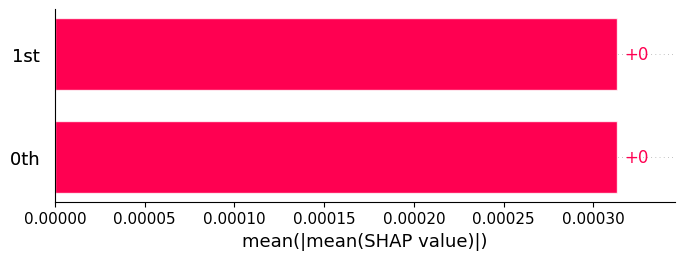

In [9]:
def run_shap_analysis(model_name, texts, labels):
    print(f"\nRunning SHAP analysis for {model_name}...")
    
    # 重新載入模型和 Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    
    # 這裡為了演示，我們只用少量數據 (前 10 筆) 來跑 SHAP，實際應用可取 50-100 筆
    # 這裡需要建立一個 pipeline 讓 SHAP 調用
    from transformers import pipeline
    pred = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1, return_all_scores=True)
    
    # 建立 SHAP Explainer
    explainer = shap.Explainer(pred)
    
    # 選擇部分測試資料 (例如 Label 為 1 的樣本，想知道為什麼模型預測會住院很久)
    # 這裡簡單取前 5 筆
    sample_texts = texts[:5].tolist()
    
    shap_values = explainer(sample_texts)
    
    # 視覺化第一個樣本的 SHAP 值
    print("Generating SHAP visualization...")
    shap.plots.text(shap_values[0])
    
    # 如果需要 Bar chart 總結
    shap.plots.bar(shap_values.mean(0))

# 執行 SHAP (以 BioClinicalBERT 為例)
# 注意：這會跑比較久
run_shap_analysis(clinicalbert_name, texts, labels)